In [18]:
import pandas as pd 

In [19]:
df = pd.read_csv("flight_data_2018_to_2022.csv")

C:\Users\carhol\AppData\Local\Temp\ipykernel_20116\3205378640.py:1: DtypeWarning: Columns (11,13,78,85,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flight_data_2018_to_2022.csv")


In [20]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,2022,1,1,6,4,2022-01-06,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2022,1,1,6,4,2022-01-06,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2022,1,1,6,4,2022-01-06,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2022,1,1,6,4,2022-01-06,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2022,1,1,6,4,2022-01-06,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563737 entries, 0 to 563736
Columns: 120 entries, Year to Unnamed: 119
dtypes: float64(72), int64(23), object(25)
memory usage: 516.1+ MB


In [6]:
for col in df.columns:
    print(col)

Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Marketing_Airline_Network
Operated_or_Branded_Code_Share_Partners
DOT_ID_Marketing_Airline
IATA_Code_Marketing_Airline
Flight_Number_Marketing_Airline
Originally_Scheduled_Code_Share_Airline
DOT_ID_Originally_Scheduled_Code_Share_Airline
IATA_Code_Originally_Scheduled_Code_Share_Airline
Flight_Num_Originally_Scheduled_Code_Share_Airline
Operating_Airline 
DOT_ID_Operating_Airline
IATA_Code_Operating_Airline
Tail_Number
Flight_Number_Operating_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime

# Problem: Can we predict flight delay risk before departure to support operational and business decisions? 

## Data Cleaning & Feature Engineering

In [23]:
df_clean = df.copy() 

In [24]:
df_clean.columns = df_clean.columns.str.strip()

In [25]:
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains("^Unnamed")]

In [26]:
df_clean = df_clean.drop_duplicates()

In [27]:
#Removing "cancelled" & "diverted" flights since airlines do not treat these flights as "normal delays". Not removed causes noisy
#data and woul impact the break logic negatively.


df_clean = df_clean[
    (df_clean["Cancelled"] == 0) &
    (df_clean["Diverted"] == 0)
]

In [28]:
assert "ArrDelayMinutes" in df_clean.columns, "ArrDelayMinutes missing!"

In [29]:
df_clean["Delayed"] = (df_clean["ArrDelayMinutes"] > 15).astype(int)

In [30]:
#Removing data leakage columns: these are cols with post-event information.
#Not removing causes models later on look perfect BUT useless! 

leakage_cols = [
    "ArrDelay", "ArrDelayMinutes", "ArrDel15",
    "DepDelay", "DepDelayMinutes", "DepDel15",
    "TaxiOut", "TaxiIn",
    "WheelsOff", "WheelsOn",
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay",
    "ActualElapsedTime", "AirTime"
]

df_clean = df_clean.drop(columns=leakage_cols, errors="ignore")

In [31]:
#Removing diversion cols (diverted flights): aircraft id not land at its scheduled destination, followed a different operational process,Or,
#has completely different delay logic. Examples: Weather diversion, emergency landing, airport closure, etc...

div_cols = [c for c in df_clean.columns if c.startswith("Div")]
df_clean = df_clean.drop(columns=div_cols, errors="ignore")

In [32]:
#Keeping only pre-departure decision features given project's main focus.

keep_cols = [
    "Year", "Month", "DayofMonth", "DayOfWeek",
    "Marketing_Airline_Network", "Operating_Airline",
    "Origin", "Dest",
    "CRSDepTime", "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "Delayed"
]

df_clean = df_clean[keep_cols] 

In [33]:
# Drop rows with missing target (rare)
df_clean = df_clean.dropna(subset=["Delayed"])

# Numeric columns → median
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

# Categorical columns → "Unknown"
cat_cols = df_clean.select_dtypes(include=["object"]).columns
df_clean[cat_cols] = df_clean[cat_cols].fillna("Unknown")

In [34]:
#Sampling

df_clean = df_clean.sample(200_000, random_state=42)

In [35]:
df_clean.info()

print("Delayed in columns:", "Delayed" in df_clean.columns)
print("ArrDelayMinutes present:", "ArrDelayMinutes" in df_clean.columns) 

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 412005 to 133882
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       200000 non-null  int64  
 1   Month                      200000 non-null  int64  
 2   DayofMonth                 200000 non-null  int64  
 3   DayOfWeek                  200000 non-null  int64  
 4   Marketing_Airline_Network  200000 non-null  object 
 5   Operating_Airline          200000 non-null  object 
 6   Origin                     200000 non-null  object 
 7   Dest                       200000 non-null  object 
 8   CRSDepTime                 200000 non-null  int64  
 9   CRSArrTime                 200000 non-null  int64  
 10  CRSElapsedTime             200000 non-null  float64
 11  Distance                   200000 non-null  float64
 12  Delayed                    200000 non-null  int64  
dtypes: float64(2), int64(7), obje

In [37]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
num_cols  

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Delayed'],
      dtype='object')

In [38]:
corr = df_clean[num_cols].corr()
corr["Delayed"].sort_values(ascending=False) 

Delayed           1.000000
CRSDepTime        0.082426
CRSArrTime        0.068150
DayOfWeek         0.060979
Distance          0.010921
CRSElapsedTime    0.008407
DayofMonth       -0.168902
Year                   NaN
Month                  NaN
Name: Delayed, dtype: float64

In [40]:
df_clean["DepHour"] = df_clean["CRSDepTime"] // 100

C:\Users\carhol\AppData\Local\Temp\ipykernel_20116\233970448.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df_clean.groupby(


Text(0.5, 1.0, 'Delay Risk by Scheduled Departure Time')

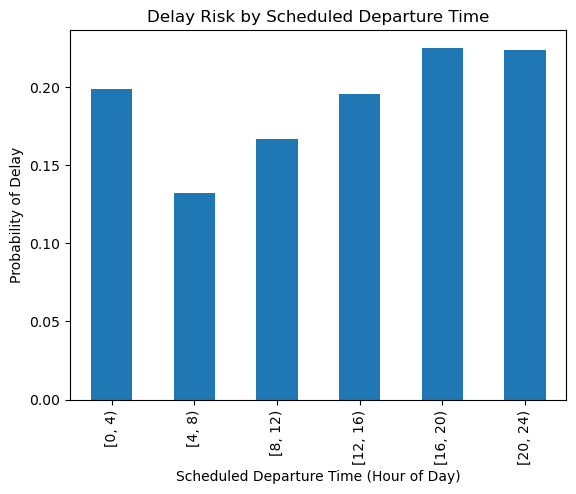

In [42]:
ax = df_clean.groupby(
    pd.cut(df_clean["DepHour"], bins=[0, 4, 8, 12, 16, 20, 24], right=False)
)["Delayed"].mean().plot(kind="bar")

ax.set_xlabel("Scheduled Departure Time (Hour of Day)")
ax.set_ylabel("Probability of Delay")
ax.set_title("Delay Risk by Scheduled Departure Time")

#The 0–4 AM window often shows a high delay rate because it contains fewer flights, and those flights are disproportionately affected by 
#upstream disruptions from the previous day.

In [43]:
df_clean.groupby(
    pd.cut(df_clean["DepHour"], bins=[0, 4, 8, 12, 16, 20, 24], right=False)
)["Delayed"].count()

#low number of flight (0-4)... 

C:\Users\carhol\AppData\Local\Temp\ipykernel_20116\1290512280.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby(


DepHour
[0, 4)        620
[4, 8)      31249
[8, 12)     51160
[12, 16)    49196
[16, 20)    47388
[20, 24)    20387
Name: Delayed, dtype: int64

In [44]:
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ["0–4", "4–8", "8–12", "12–16", "16–20", "20–24"]

summary = (
    df_clean
    .assign(DepBin=pd.cut(df_clean["DepHour"], bins=bins, labels=labels, right=False))
    .groupby("DepBin")["Delayed"]
    .mean()
)

C:\Users\carhol\AppData\Local\Temp\ipykernel_20116\4260250404.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DepBin")["Delayed"]


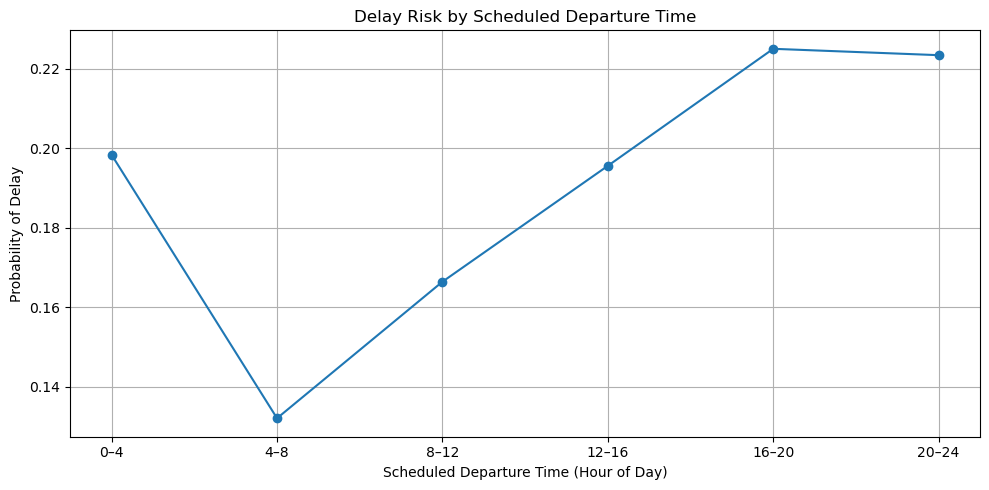

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

summary.plot(
    kind="line",
    marker="o"
)

plt.xlabel("Scheduled Departure Time (Hour of Day)")
plt.ylabel("Probability of Delay")
plt.title("Delay Risk by Scheduled Departure Time")
plt.grid(True)
plt.tight_layout()
plt.savefig("delay_risk_by_departure_time.png", dpi=300)
plt.show()

In [48]:
df_clean.isnull().sum()

Year                         0
Month                        0
DayofMonth                   0
DayOfWeek                    0
Marketing_Airline_Network    0
Operating_Airline            0
Origin                       0
Dest                         0
CRSDepTime                   0
CRSArrTime                   0
CRSElapsedTime               0
Distance                     0
Delayed                      0
DepHour                      0
dtype: int64

In [49]:
df_clean.describe()


#Insight:
#Target variable (delayed): ~18.8% of flights are delayed (>15 min) & ~81.2% are on time--> Class imbalance-->accuracy alone = misleading
#Roughly 19% of flights experience significant delays, making this an imbalanced but operationally meaningful classification problem
#A small number of records exhibit negative scheduled elapsed times, likely due to scheduling or time-zone artifacts in the raw data. 
#These values are rare and do not materially affect the delay-risk analysis.

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Delayed,DepHour
count,200000.0,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2022.0,1.0,16.192445,4.005135,1327.247520,1499.806080,144.794055,804.499885,0.188065,13.002655
std,0.0,0.0,8.868133,2.076059,480.217387,504.849882,72.407030,591.532111,0.390765,4.776777
min,2022.0,1.0,1.000000,1.000000,1.000000,1.000000,-48.000000,31.000000,0.000000,0.000000
25%,2022.0,1.0,9.000000,2.000000,922.000000,1119.000000,91.000000,370.000000,0.000000,9.000000
50%,2022.0,1.0,16.000000,4.000000,1321.000000,1522.000000,128.000000,651.000000,0.000000,13.000000
75%,2022.0,1.0,24.000000,6.000000,1726.000000,1919.000000,175.000000,1050.000000,0.000000,17.000000
max,2022.0,1.0,31.000000,7.000000,2359.000000,2359.000000,685.000000,5095.000000,1.000000,23.000000


In [50]:
df_clean["Delayed"].unique()

array([0, 1])

In [51]:
df_clean["Delayed"].dtype

dtype('int64')

In [52]:
df_clean["Delayed"].value_counts()

Delayed
0    162387
1     37613
Name: count, dtype: int64

In [53]:
df_clean.dtypes 

Year                           int64
Month                          int64
DayofMonth                     int64
DayOfWeek                      int64
Marketing_Airline_Network     object
Operating_Airline             object
Origin                        object
Dest                          object
CRSDepTime                     int64
CRSArrTime                     int64
CRSElapsedTime               float64
Distance                     float64
Delayed                        int64
DepHour                        int64
dtype: object

In [54]:
#Checking high/low cardinality (number of unique values) to see which ones need to be converted to dummies later-->
#low cardinality-->safe to one-hot encode (marketing-airline)




cat_cols = [
    "Marketing_Airline_Network",
    "Operating_Airline",
    "Origin",
    "Dest"
]

for col in cat_cols:
    print(f"{col}: {df_clean[col].nunique()} unique values")  

Marketing_Airline_Network: 10 unique values
Operating_Airline: 21 unique values
Origin: 368 unique values
Dest: 369 unique values


In [56]:
for col in cat_cols:
    print(f"\nTop values for {col}:")
    print(df_clean[col].value_counts().head(10)) 




#Insight:
#Airline categories are limited and well represented, making them suitable for one-hot encoding. 
#In contrast, airport identifiers exhibit high cardinality and a long-tailed distribution, 
#so they were excluded from the baseline model to avoid sparsity and overfitting.


Top values for Marketing_Airline_Network:
Marketing_Airline_Network
AA    53212
DL    42293
UA    36200
WN    34581
AS    10333
B6     7277
NK     6426
F9     4415
G4     3079
HA     2184
Name: count, dtype: int64

Top values for Operating_Airline:
Operating_Airline
WN    34581
DL    25159
AA    25105
OO    22348
UA    16290
YX     9246
MQ     8172
9E     7614
B6     7277
OH     6901
Name: count, dtype: int64

Top values for Origin:
Origin
ATL    9274
DFW    8406
ORD    8199
DEN    7699
CLT    6408
LAX    5743
PHX    4975
LGA    4783
LAS    4691
SEA    4556
Name: count, dtype: int64

Top values for Dest:
Dest
ATL    9324
ORD    8393
DFW    8391
DEN    7641
CLT    6362
LAX    5736
PHX    4927
LGA    4878
LAS    4746
SEA    4557
Name: count, dtype: int64


In [57]:
df_clean[["Origin", "Dest"]].head(10)

#These are IATA airport codes (airport identifiers)
#Origin and destination variables consist of standardized airport identifiers that encode network structure rather than direct numerical information, 
#motivating aggregate feature engineering to capture congestion and traffic effects

,Origin,Dest
412005,JFK,BOS
45333,LAX,JFK
113611,IND,CLT
45428,LGA,ATL
509959,IAH,SFO
508983,LAX,EWR
507054,IAD,SFO
416388,LAX,JFK
418508,LGA,BOS
302064,JFK,CLT


In [58]:
#Origin traffic
#Airport code → number of flights in the dataset. Example: ATL → 9000+ flights

origin_counts = df_clean["Origin"].value_counts()

In [59]:
#Destination traffic

dest_counts = df_clean["Dest"].value_counts()

In [60]:
#Map counts back to the dataframe
#No rows added or removed. No missing values introduced. Fully numeric features created.

df_clean["Origin_Flight_Count"] = df_clean["Origin"].map(origin_counts)
df_clean["Dest_Flight_Count"] = df_clean["Dest"].map(dest_counts)

In [61]:
df_clean[["Origin_Flight_Count", "Dest_Flight_Count"]].isnull().sum()

Origin_Flight_Count    0
Dest_Flight_Count      0
dtype: int64

In [62]:
df_clean[["Origin_Flight_Count", "Dest_Flight_Count"]].describe() 

,Origin_Flight_Count,Dest_Flight_Count
count,200000.000000,200000.000000
mean,3569.479510,3581.083600
std,2781.752497,2799.745896
min,1.000000,1.000000
25%,1180.000000,1151.000000
50%,3500.000000,3538.000000
75%,4975.000000,4927.000000
max,9274.000000,9324.000000


In [63]:
df_clean.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network',
       'Operating_Airline', 'Origin', 'Dest', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Delayed', 'DepHour',
       'Origin_Flight_Count', 'Dest_Flight_Count'],
      dtype='object')

In [65]:
import numpy as np

df_clean["Origin_Flight_Count_Log"] = np.log1p(df_clean["Origin_Flight_Count"])
df_clean["Dest_Flight_Count_Log"] = np.log1p(df_clean["Dest_Flight_Count"])

In [66]:
df_clean[[
    "Origin_Flight_Count",
    "Origin_Flight_Count_Log",
    "Dest_Flight_Count",
    "Dest_Flight_Count_Log"
]].head()

,Origin_Flight_Count,Origin_Flight_Count_Log,Dest_Flight_Count,Dest_Flight_Count_Log
412005,3726,8.223359,3302,8.102586
45333,5743,8.655911,3780,8.237744
113611,1238,7.122060,6362,8.758255
45428,4783,8.473032,9324,9.140454
509959,4409,8.391630,3565,8.179200


In [67]:
df_clean[[
    "Origin_Flight_Count_Log",
    "Dest_Flight_Count_Log"
]].describe()

,Origin_Flight_Count_Log,Dest_Flight_Count_Log
count,200000.000000,200000.000000
mean,7.643946,7.644307
std,1.309627,1.312808
min,0.693147,0.693147
25%,7.074117,7.049255
50%,8.160804,8.171599
75%,8.512382,8.502689
max,9.135078,9.140454


In [68]:
df_lr = pd.get_dummies(
    df_clean,
    columns=["Marketing_Airline_Network", "Operating_Airline"],
    drop_first=True
)

In [69]:
df_lr.columns 

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest',
       'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'Delayed',
       'DepHour', 'Origin_Flight_Count', 'Dest_Flight_Count',
       'Origin_Flight_Count_Log', 'Dest_Flight_Count_Log',
       'Marketing_Airline_Network_AS', 'Marketing_Airline_Network_B6',
       'Marketing_Airline_Network_DL', 'Marketing_Airline_Network_F9',
       'Marketing_Airline_Network_G4', 'Marketing_Airline_Network_HA',
       'Marketing_Airline_Network_NK', 'Marketing_Airline_Network_UA',
       'Marketing_Airline_Network_WN', 'Operating_Airline_AA',
       'Operating_Airline_AS', 'Operating_Airline_B6', 'Operating_Airline_C5',
       'Operating_Airline_DL', 'Operating_Airline_F9', 'Operating_Airline_G4',
       'Operating_Airline_G7', 'Operating_Airline_HA', 'Operating_Airline_MQ',
       'Operating_Airline_NK', 'Operating_Airline_OH', 'Operating_Airline_OO',
       'Operating_Airline_PT', 'Operating_Airline_QX', 'Operating_Airli

In [71]:
df_lr = df_lr.drop(columns=["Year"], errors="ignore")

In [72]:
df_lr.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'CRSDepTime',
       'CRSArrTime', 'CRSElapsedTime', 'Distance', 'Delayed', 'DepHour',
       'Origin_Flight_Count', 'Dest_Flight_Count', 'Origin_Flight_Count_Log',
       'Dest_Flight_Count_Log', 'Marketing_Airline_Network_AS',
       'Marketing_Airline_Network_B6', 'Marketing_Airline_Network_DL',
       'Marketing_Airline_Network_F9', 'Marketing_Airline_Network_G4',
       'Marketing_Airline_Network_HA', 'Marketing_Airline_Network_NK',
       'Marketing_Airline_Network_UA', 'Marketing_Airline_Network_WN',
       'Operating_Airline_AA', 'Operating_Airline_AS', 'Operating_Airline_B6',
       'Operating_Airline_C5', 'Operating_Airline_DL', 'Operating_Airline_F9',
       'Operating_Airline_G4', 'Operating_Airline_G7', 'Operating_Airline_HA',
       'Operating_Airline_MQ', 'Operating_Airline_NK', 'Operating_Airline_OH',
       'Operating_Airline_OO', 'Operating_Airline_PT', 'Operating_Airline_QX',
       'Operating_Airline_UA', 

In [73]:
df_lr = df_lr.drop(
    columns=[
        "Origin",
        "Dest",
        "DepHour",
        "Origin_Flight_Count",
        "Dest_Flight_Count"
    ],
    errors="ignore"
)

In [74]:
df_lr.columns 

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Delayed', 'Origin_Flight_Count_Log',
       'Dest_Flight_Count_Log', 'Marketing_Airline_Network_AS',
       'Marketing_Airline_Network_B6', 'Marketing_Airline_Network_DL',
       'Marketing_Airline_Network_F9', 'Marketing_Airline_Network_G4',
       'Marketing_Airline_Network_HA', 'Marketing_Airline_Network_NK',
       'Marketing_Airline_Network_UA', 'Marketing_Airline_Network_WN',
       'Operating_Airline_AA', 'Operating_Airline_AS', 'Operating_Airline_B6',
       'Operating_Airline_C5', 'Operating_Airline_DL', 'Operating_Airline_F9',
       'Operating_Airline_G4', 'Operating_Airline_G7', 'Operating_Airline_HA',
       'Operating_Airline_MQ', 'Operating_Airline_NK', 'Operating_Airline_OH',
       'Operating_Airline_OO', 'Operating_Airline_PT', 'Operating_Airline_QX',
       'Operating_Airline_UA', 'Operating_Airline_WN', 'Operating_Airline_YV',
       'Operating_Airline_YX', '

## Split to X and y

In [75]:
# Define target
y = df_lr["Delayed"]

# Define features
X = df_lr.drop(columns=["Delayed"])

In [76]:
X.shape, y.shape

((200000, 38), (200000,))

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [78]:
X_train.shape, X_test.shape

((160000, 38), (40000, 38))

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

# Numeric columns to scale
numeric_cols = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "Origin_Flight_Count_Log",
    "Dest_Flight_Count_Log"
]

# Preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    remainder="passthrough"
)

In [80]:
preprocessor 

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Month', 'DayofMonth', 'DayOfWeek',
                                  'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime',
                                  'Distance', 'Origin_Flight_Count_Log',
                                  'Dest_Flight_Count_Log'])])

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# defining classifier
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

# Building the pipeline
pipe_lr = make_pipeline(
    preprocessor,
    log_reg
)

In [82]:
pipe_lr 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Month', 'DayofMonth',
                                                   'DayOfWeek', 'CRSDepTime',
                                                   'CRSArrTime',
                                                   'CRSElapsedTime', 'Distance',
                                                   'Origin_Flight_Count_Log',
                                                   'Dest_Flight_Count_Log'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1))])

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "logisticregression__C": [0.01, 0.1, 1, 10]
}

In [85]:
grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring="roc_auc",                        #roc_auc is chosen because of imbalanced binary classification
    n_jobs=-1
)

In [86]:
grid_lr.fit(X_train, y_train)

C:\Users\carhol\AppData\Local\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Month',
                                                                          'DayofMonth',
                                                                          'DayOfWeek',
                                                                          'CRSDepTime',
                                                                          'CRSArrTime',
                                                                          'CRSElapsedTime',
                                                                          'Distance',
                                                                          'Origin_Flight_Count_Log',
                                                                          'Dest_Flight_Count_Log'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10]},
             scoring='roc_auc')

In [88]:
grid_lr.best_score_

np.float64(0.6563461208502377)

In [89]:
grid_lr.best_params_

{'logisticregression__C': 10}

In [90]:
# Create RF feature set from df_clean (not df_lr)-->model needs raw data here not the log version.

X_rf = df_clean.drop(columns=["Delayed"])

y_rf = df_clean["Delayed"]

In [91]:
X_rf.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network',
       'Operating_Airline', 'Origin', 'Dest', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'DepHour', 'Origin_Flight_Count',
       'Dest_Flight_Count', 'Origin_Flight_Count_Log',
       'Dest_Flight_Count_Log'],
      dtype='object')

In [92]:
X_rf = X_rf.drop(
    columns=[
        "Year",
        "Origin",
        "Dest",
        "DepHour",
        "Origin_Flight_Count_Log",
        "Dest_Flight_Count_Log"
    ],
    errors="ignore"
)

In [93]:
X_rf.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network',
       'Operating_Airline', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime',
       'Distance', 'Origin_Flight_Count', 'Dest_Flight_Count'],
      dtype='object')

In [94]:
#Dummy variables for RF model

X_rf = pd.get_dummies(
    X_rf,
    columns=["Marketing_Airline_Network", "Operating_Airline"],
    drop_first=True
)

In [95]:
X_rf.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Origin_Flight_Count',
       'Dest_Flight_Count', 'Marketing_Airline_Network_AS',
       'Marketing_Airline_Network_B6', 'Marketing_Airline_Network_DL',
       'Marketing_Airline_Network_F9', 'Marketing_Airline_Network_G4',
       'Marketing_Airline_Network_HA', 'Marketing_Airline_Network_NK',
       'Marketing_Airline_Network_UA', 'Marketing_Airline_Network_WN',
       'Operating_Airline_AA', 'Operating_Airline_AS', 'Operating_Airline_B6',
       'Operating_Airline_C5', 'Operating_Airline_DL', 'Operating_Airline_F9',
       'Operating_Airline_G4', 'Operating_Airline_G7', 'Operating_Airline_HA',
       'Operating_Airline_MQ', 'Operating_Airline_NK', 'Operating_Airline_OH',
       'Operating_Airline_OO', 'Operating_Airline_PT', 'Operating_Airline_QX',
       'Operating_Airline_UA', 'Operating_Airline_WN', 'Operating_Airline_YV',
       'Operating_Airline_YX', 'Operating_Airline_Z

In [96]:
X_rf_train = X_rf.loc[X_train.index]
X_rf_test  = X_rf.loc[X_test.index]

y_rf_train = y_rf.loc[X_train.index]
y_rf_test  = y_rf.loc[X_test.index]

In [97]:
X_rf_train.shape, X_rf_test.shape

((160000, 38), (40000, 38))

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Defining Random Forest classifier
rf_clf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

# Building the pipeline (no preprocessing needed)
pipe_rf = make_pipeline(rf_clf)

In [99]:
pipe_rf

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [100]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "randomforestclassifier__n_estimators": [100, 300],
    "randomforestclassifier__max_depth": [10, 30, None],
    "randomforestclassifier__min_samples_leaf": [1, 5]
}

In [101]:
param_grid_rf

{'randomforestclassifier__n_estimators': [100, 300],
 'randomforestclassifier__max_depth': [10, 30, None],
 'randomforestclassifier__min_samples_leaf': [1, 5]}

In [102]:
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

In [103]:
grid_rf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [10, 30, None],
                         'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [100, 300]},
             scoring='roc_auc')

In [104]:
grid_rf.fit(X_rf_train, y_rf_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [10, 30, None],
                         'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [100, 300]},
             scoring='roc_auc')

In [105]:
grid_rf.best_score_

np.float64(0.7475649143708892)

In [106]:
grid_rf.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 300}

In [107]:
#XGBoost
# XGBoost uses the same features as Random Forest

X_xgb = X_rf.copy()
y_xgb = y_rf.copy()

In [108]:
X_xgb.shape, y_xgb.shape

((200000, 38), (200000,))

In [109]:
# Align XGBoost features with the original split

X_xgb_train = X_xgb.loc[X_train.index]
X_xgb_test  = X_xgb.loc[X_test.index]

y_xgb_train = y_xgb.loc[X_train.index]
y_xgb_test  = y_xgb.loc[X_test.index]

In [110]:
X_xgb_train.shape, X_xgb_test.shape

((160000, 38), (40000, 38))

In [112]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 2.1/72.0 MB 18.4 MB/s eta 0:00:04
   ----- ---------------------------------- 10.7/72.0 MB 34.0 MB/s eta 0:00:02
   ----------- ---------------------------- 21.0/72.0 MB 40.3 MB/s eta 0:00:02
   ------------------ --------------------- 33.3/72.0 MB 45.1 MB/s eta 0:00:01
   ------------------------ --------------- 43.8/72.0 MB 47.2 MB/s eta 0:00:01
   ---------------------------- ----------- 50.9/72.0 MB 45.6 MB/s eta 0:00:01
   -------------------------------- ------- 58.7/72.0 MB 44.0 MB/s eta 0:00:01
   ------------------------------------- -- 66.8/72.0 MB 42.8 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 43.8 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 40.3 MB/s eta 0:00:00


In [113]:
from xgboost import XGBClassifier

# Define XGBoost classifier (baseline, safe defaults)
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",      # faster & memory-efficient
    n_jobs=-1,
    random_state=42
)

In [114]:
from sklearn.pipeline import make_pipeline

pipe_xgb = make_pipeline(xgb_clf)

In [115]:
pipe_xgb

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [116]:
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    "xgbclassifier__n_estimators": [200, 400],
    "xgbclassifier__max_depth": [4, 6],
    "xgbclassifier__learning_rate": [0.05, 0.1],
    "xgbclassifier__subsample": [0.8],
    "xgbclassifier__colsample_bytree": [0.8]
}

In [117]:
param_grid_xgb

{'xgbclassifier__n_estimators': [200, 400],
 'xgbclassifier__max_depth': [4, 6],
 'xgbclassifier__learning_rate': [0.05, 0.1],
 'xgbclassifier__subsample': [0.8],
 'xgbclassifier__colsample_bytree': [0.8]}

In [118]:
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

In [119]:
grid_xgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_typ...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__colsample_bytree': [0.8],
                         'xgbclassifier__learning_rate': [0.05, 0.1],
                         'xgbclassifier__max_depth': [4, 6],
                         'xgbclassifier__n_estimators': [200, 400],
                         'xgbclassifier__subsample': [0.8]},
             scoring='roc_auc')

In [120]:
grid_xgb.fit(X_xgb_train, y_xgb_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_typ...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__colsample_bytree': [0.8],
                         'xgbclassifier__learning_rate': [0.05, 0.1],
                         'xgbclassifier__max_depth': [4, 6],
                         'xgbclassifier__n_estimators': [200, 400],
                         'xgbclassifier__subsample': [0.8]},
             scoring='roc_auc')

In [121]:
grid_xgb.best_score_

np.float64(0.757414323370688)

In [122]:
grid_xgb.best_params_

{'xgbclassifier__colsample_bytree': 0.8,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__n_estimators': 400,
 'xgbclassifier__subsample': 0.8}

In [123]:
#Insight:
#“Gradient boosting delivered the strongest performance, achieving a cross-validated ROC-AUC of 0.76 using only pre-departure information, 
#demonstrating the value of modeling non-linear operational interactions.”

In [125]:
from sklearn.metrics import roc_auc_score

# Logistic Regression test predictions
y_lr_proba = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

# ROC-AUC on test set
lr_test_auc = roc_auc_score(y_test, y_lr_proba)

lr_test_auc

np.float64(0.656095254576444)

In [126]:
# Random Forest test predictions

y_rf_proba = grid_rf.best_estimator_.predict_proba(X_rf_test)[:, 1]

# ROC-AUC on test set
rf_test_auc = roc_auc_score(y_rf_test, y_rf_proba)

rf_test_auc

np.float64(0.7515894427128422)

In [127]:
# XGBoost test predictions

y_xgb_proba = grid_xgb.best_estimator_.predict_proba(X_xgb_test)[:, 1]

# ROC-AUC on test set
xgb_test_auc = roc_auc_score(y_xgb_test, y_xgb_proba)

xgb_test_auc

np.float64(0.7603519890563889)

In [128]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # Handle probability output safely
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    print(f"\n===== {model_name.upper()} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, pos_label=1))
    print("Recall:", recall_score(y_test, y_pred, pos_label=1))
    print("F1-score:", f1_score(y_test, y_pred, pos_label=1))

    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    else:
        print("ROC AUC: Not available")

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [129]:
# Logistic Regression
evaluate_model(
    model=grid_lr.best_estimator_,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression"
)

# Random Forest
evaluate_model(
    model=grid_rf.best_estimator_,
    X_test=X_rf_test,
    y_test=y_rf_test,
    model_name="Random Forest"
)

# XGBoost
evaluate_model(
    model=grid_xgb.best_estimator_,
    X_test=X_xgb_test,
    y_test=y_xgb_test,
    model_name="XGBoost"
)



===== LOGISTIC REGRESSION =====
Accuracy: 0.812725
Precision: 0.625
Recall: 0.010634055562940316
F1-score: 0.020912299045876357
ROC AUC: 0.656095254576444
Confusion Matrix:
 [[32429    48]
 [ 7443    80]]

===== RANDOM FOREST =====
Accuracy: 0.8283
Precision: 0.6920821114369502
Recall: 0.15685231955336967
F1-score: 0.25574338968357174
ROC AUC: 0.7515894427128422
Confusion Matrix:
 [[31952   525]
 [ 6343  1180]]

===== XGBOOST =====
Accuracy: 0.8315
Precision: 0.6689684937419076
Recall: 0.20603482653196864
F1-score: 0.3150406504065041
ROC AUC: 0.7603519890563889
Confusion Matrix:
 [[31710   767]
 [ 5973  1550]]


In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Get fitted XGBoost model
xgb_model = grid_xgb.best_estimator_.named_steps["xgbclassifier"]

# Get feature names
feature_names = X_xgb_train.columns

# Build importance DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Show top 15
importance_df.head(15)

,Feature,Importance
17,Marketing_Airline_Network_WN,0.097405
10,Marketing_Airline_Network_B6,0.059822
1,DayofMonth,0.051497
20,Operating_Airline_B6,0.048514
18,Operating_Airline_AA,0.045461
22,Operating_Airline_DL,0.035982
11,Marketing_Airline_Network_DL,0.033346
34,Operating_Airline_WN,0.031936
29,Operating_Airline_OH,0.031484
27,Operating_Airline_MQ,0.027943


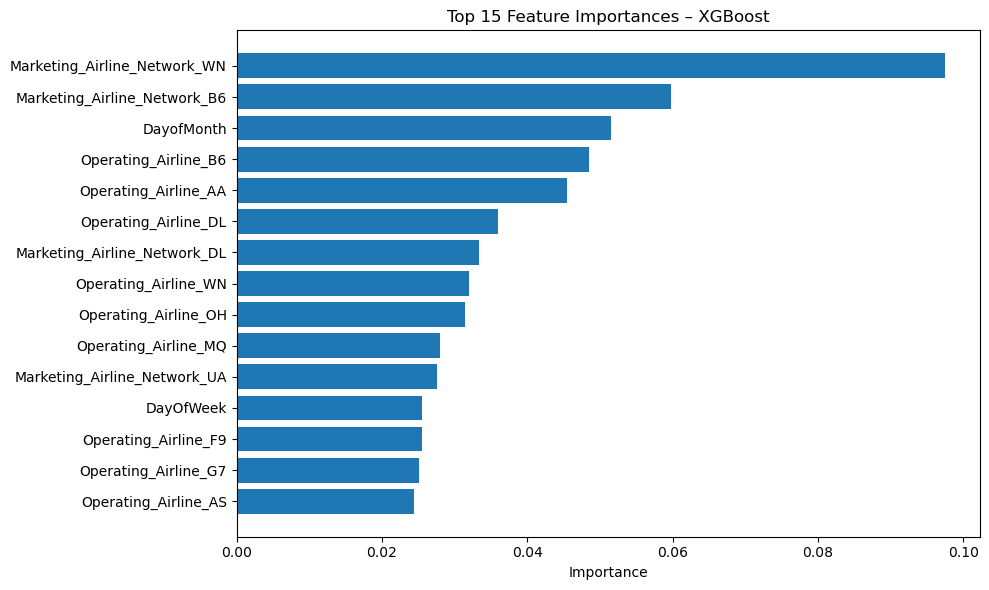

In [131]:
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df.head(15)["Feature"][::-1],
    importance_df.head(15)["Importance"][::-1]
)
plt.title("Top 15 Feature Importances – XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

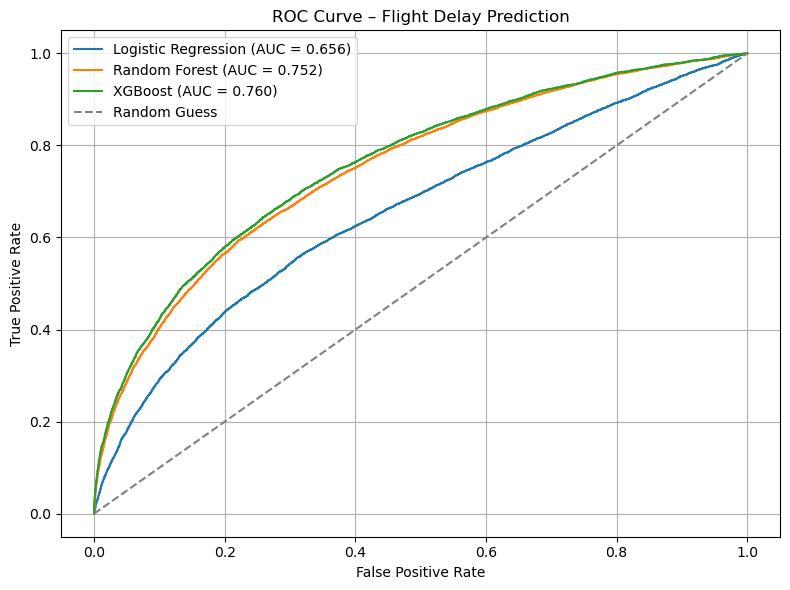

In [132]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_proba)
auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_rf_test, y_rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_xgb_test, y_xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Flight Delay Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


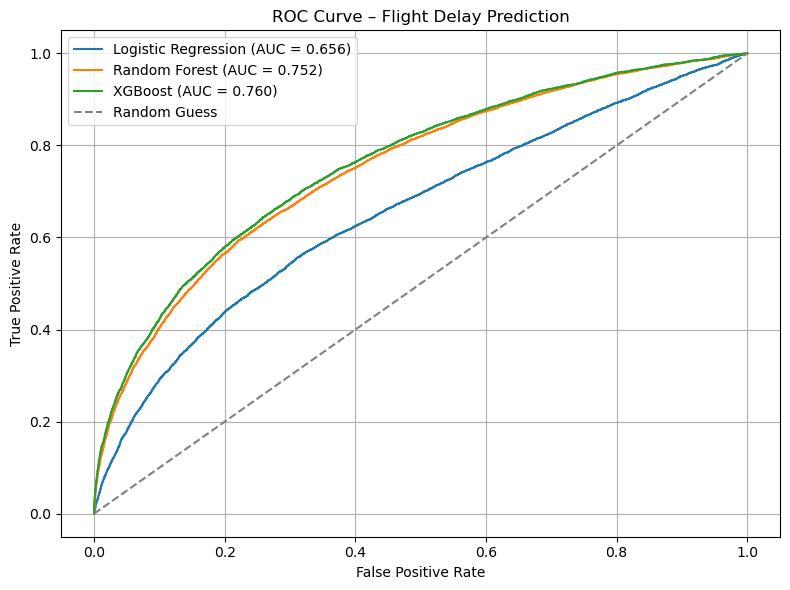

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_proba)
auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_rf_test, y_rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_xgb_test, y_xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Flight Delay Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()

# ✅ Save image for presentation
plt.savefig("roc_curve_flight_delay_models.png", dpi=300)

plt.show()
